### Research \& Development Project
___
This is the step-by-step guide to what I did during the project. Following these steps will provide the same results
at which I arrived.<br>
It should be noted that in order for the shell script to properly work, all chunks of code post Part 2 must be tagged
accordingly. <br>
See '#CREATE TEMP PATHS' in the shell script for more information. Alternatively, download this notebook and take note of the tags for each cell.
#### Part 1: Setup
* __Step 1.1__: Setup necessary parameters, create the virtual environment, install necessary packages.<br>
Once this is done, set the kernel to said environment.<br>
For this to work, follow the instructions in the README.txt

* __Step 1.2__: Retrieve and convert OpenNMT's NLLB transformer.

In [ ]:
# Retrieve the model from https://www.opennmt.net/Models-py/
!wget https://s3.amazonaws.com/opennmt-models/nllb-200/nllb-200-3.3B-onmt.pt
!wget https://s3.amazonaws.com/opennmt-models/nllb-200/flores200_sacrebleu_tokenizer_spm.model
!mkdir nmt_resources paraphrases
!unzip paraphrases.zip paraphrases
!mv paraphrases.zip nmt_resources
!mv nllb-200-3.3B-onmt.pt flores200_sacrebleu_tokenizer_spm.model nmt_resources/
!ct2-opennmt-py-converter --model nmt_resources/nllb-200-3.3B-onmt.pt --quantization int8 --output_dir nmt_resources/nllb-200-3.3B-int8

#### Part 2: Translation
___
The following chunks of code will load the models, translate the source text, and store the translated target text.
* __Step 2.1__: Load & run NMT.

In [ ]:
import ctranslate2
import sentencepiece as spm
import torch
import sys
import os

#--------------------Part 2.1: LOAD NMT--------------------#
''' Test for GPU and load translator '''

# 2.1.0: Set device to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 2.1.1: Instantiate the translator
ct_model_path = 'nmt_resources/nllb-200-3.3B-int8'
sp_model_path = 'nmt_resources/flores200_sacrebleu_tokenizer_spm.model'

sp = spm.SentencePieceProcessor()
sp.load(sp_model_path)

print(ctranslate2.__version__)
resrv_mem = torch.cuda.memory.memory_reserved(0)
alloc_mem = torch.cuda.memory.memory_allocated(0)
total_mem = torch.cuda.get_device_properties(0).total_memory
print(f"\n GPU available: {torch.cuda.is_available()}\n",
      f"Device name: {torch.cuda.get_device_name(0)}\n",
      f"Total memory on device: {total_mem / 1024**3:.2f} GB\n",
      f"Memory on device currently reserved (set aside): {resrv_mem / 1024**3:.2f} GB\n",
      f"Memory on device currently allocated (in use): {alloc_mem / 1024**3:.2f} GB\n")

#--------------------PARt 2.2: RUN NMT--------------------#
''' Encode input, translate source text, decode output '''

# 2.1.2 Define source and target languages
src_lang = 'eng_Latn'
tgt_lang = 'deu_Latn'

# 2.1.3: Define paths
inp_path = f'paraphrases/eng_Latn{sys.argv[1]}.txt'
out_path = f'translations/nmt_Latn{sys.argv[1]}.de'

beam_size = 4

# 2.1.4: Open and read input file; return lines
with open(inp_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()

# 2.1.5: Define source and target prefixes
source_sents = [line.strip() for line in lines]
print(src_lang, source_sents[0], sep=' --> ')
target_prefix = [[tgt_lang]] * len(source_sents)

# 2.1.6: Subword source sentences
source_sents_subword = sp.encode_as_pieces(source_sents)
source_sents_subword = [[src_lang] + sent + ['</s>'] for sent in source_sents_subword]

# 2.1.7: Translate source sentences
translator = ctranslate2.Translator(ct_model_path, device=device)
translations = translator.translate_batch(source_sents_subword, 
                                          batch_type='tokens',
                                          max_batch_size=2048,
                                          beam_size=beam_size,
                                          target_prefix=target_prefix)
translations = [translation.hypotheses[0] for translation in translations]

# 2.1.8: Desubword target sentences
translations_desubword = sp.decode(translations)
translations_desubword = [sent[len(tgt_lang):].strip() for sent in translations_desubword]
print(tgt_lang, translations_desubword[0], sep=' --> ')

# 2.1.9: Create target directory
os.makedirs('translations', exist_ok=True)

# 2.1.10: Write translation to output file
with open(out_path, 'w', encoding='utf-8') as f:
    for line in translations_desubword:
        f.write(line.strip() + '\n')
print(f'Translations successfully executed and saved to: {out_path}.')

* __Part 2.2__: Load & run LLM.

In [ ]:
import os
import sys
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer  as at

#--------------------Part 2.2: LOAD LLM--------------------#
''' Test for GPU and load the model '''

# 2.2.0: Set device to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 2.2.1: Instantiate tokenizer and model
tokenizer = at.from_pretrained('meta-llama/Llama-2-13b-chat-hf')
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    'meta-llama/Llama-2-13b-chat-hf',
    device_map='auto',
    torch_dtype=torch.float16
)

# 2.2.2: [Optional]
resrv_mem = torch.cuda.memory.memory_reserved(0)
alloc_mem = torch.cuda.memory.memory_allocated(0)
total_mem = torch.cuda.get_device_properties(0).total_memory
print(f"\n GPU available: {torch.cuda.is_available()}\n",
      f"Device name: {torch.cuda.get_device_name(0)}\n",
      f"Total memory on device: {total_mem / 1024**3:.2f} GB\n",
      f"Memory on device currently reserved (set aside): {resrv_mem / 1024**3:.2f} GB\n",
      f"Memory on device currently allocated (in use): {alloc_mem / 1024**3:.2f} GB\n")

#--------------------PART 2.4: RUN LLM--------------------#
''' Formalize prompt, set temperature, translate source text '''

# 2.2.3: Define paths
inp_path = f'paraphrases/eng_Latn{sys.argv[3]}.txt'
out_path = f'translations/llm_t{sys.argv[2]}_raw_Latn{sys.argv[3]}.de'

# 2.2.4: Load source text
with open(inp_path, 'r', encoding='utf-8') as f:
    lines = [line.strip() for line in f]

# 2.2.5: Create target directory
os.makedirs('translations', exist_ok=True)

# 2.2.6: Provide prompt to model
with open(out_path, 'w', encoding='utf-8') as f:
    for i in range(0, len(lines)):
        messages = [
            {'role': 'user', 'content': f'Translate the following text from English to German: {lines[i]}'}
            ]

        # 2.2.7: Set input parameters
        inputs = tokenizer.apply_chat_template(messages, 
                                               add_generation_prompt=False,
                                               tokenize=True,
                                               return_dict=True,
                                               return_tensors='pt')
        
        # 2.2.8: Move inputs to device before generating
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # 2.2.9: Set output parameters; temperature changes for each output
        max_new_tokens = int(len(tokenizer(lines[i]).input_ids) * 1.5) + 25
        outputs = model.generate(**inputs,
                                 max_new_tokens=max_new_tokens,
                                 temperature=float(sys.argv[1])
        )

        # 2.2.10: Decode output and generate translation
        translation = tokenizer.decode(outputs[0][inputs['input_ids'].shape[-1]:], 
                                       skip_special_tokens=True).strip()

        # 2.2.11: Write to file
        f.write(translation + '\n')
print(f'Translations successfully executed and saved to: {out_path}.')

* __Part 2.3__: Clean LLM translations from noise.

In [ ]:
from langdetect import detect, LangDetectException
import shutil
import sys
import os
import re

class CleanNoise:
    def __init__(self, path, inp_file, out_file, new_subdir, old_subdir):
        self.path = path
        self.inp_file = inp_file
        self.out_file = out_file
        self.new_subdir = new_subdir
        self.old_subdir = old_subdir

    # 2.3.1: Get the raw translated lines as a list
    def get_lines(self):
        with open(os.path.join(self.old_subdir, self.inp_file), 'r', encoding='utf-8') as f:
            return f.readlines()

    # 2.3.2: Ignore blank spaces produced by the LLM
    def ignore_blank(self):
        return [line.strip() for line in self.get_lines() if not line.isspace()]

    # 2.3.3: Detect german lines and ignore overtly English noise by the LLM
    def find_deu(self):
        deu = []
        for line in self.ignore_blank():
            try:
                if detect(line) == 'de':
                    deu.append(line)
            except LangDetectException:
                pass
        return deu
    
    # 2.3.4: Filter non-overt LLM noise such as unfinished notes
    def filter_noise(self):
        pattern = r'(\*)'
        noise = []
        for line in self.find_deu():
            if not re.search(pattern, line, re.IGNORECASE):
                noise.append(line)
        return noise
    
    # 2.3.5: Save filtered german lines to new file path
    def save(self):
        os.makedirs(self.new_subdir, exist_ok=True)   # make folder for filtered translations without noise
        with open(os.path.join(self.new_subdir, self.out_file), 'w', encoding='utf-8') as f:
            for line in self.filter_noise():
                f.write(line + '\n')

    # 2.3.6: Move old raw translations to new subdirectory
    def move(self):
        os.makedirs(self.old_subdir, exist_ok=True)   # make folder for raw translations with noise
        try:
            for file in os.listdir(self.path):
                if file.startswith('llm'):
                    shutil.move(file, self.old_subdir + file)
        except Exception:
            pass

path = 'translations/'
inp_file = f'llm_{sys.argv[1]}_raw_Latn{sys.argv[2]}.de'
out_file = f'llm_{sys.argv[1]}_filtered_Latn{sys.argv[2]}.de'
new_subdir = f'translations/filtered_translations/'
old_subdir = f'translations/raw_translations/'

cn = CleanNoise(inp_file=inp_file, 
                out_file=out_file,
                new_subdir=new_subdir,
                old_subdir=old_subdir)
cn.move()
cn.save()

* __Part 2.4__: Embedd all translated texts.<br>
_Make semantic embeddings for all translations and select 1900 sentences with similar embeddings._ <br>
_This is to make sure that all translations are sentence-aligned and are ready for evaluation._

In [ ]:
from sentence_transformers import SentenceTransformer, util
import sys
import os

# 2.4.0: Define paths
os.makedirs('aligned/', exist_ok=True)

if sys.argv[1] == 'llm':                                            # Candidate will be LLM translations
    cand_file = f'llm_{sys.argv[2]}_filtered_Latn{sys.argv[3]}.de'
    cand_path = f'translations/filtered_translations/{cand_file}'
    new_cand = f'aligned/llm_{sys.argv[2]}_Latn-aligned{sys.argv[3]}.de'
elif sys.argv[1] == 'ref':                                          # Candidate will be paraphrased references
    cand_file = f'deu_Latn_{sys.argv[2]}.txt'
    cand_path = f'paraphrases/{cand_file}'
    new_cand = f'aligned/deu_Latn-aligned_{sys.argv[2]}.txt'

nmt_file = f'nmt_Latn{sys.argv[3]}.de'
nmt_path = f'translations/{nmt_file}'
new_nmt = 'aligned/nmt_Latn-aligned.de'

# 2.4.1: Load Sentence Transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# 2.4.2: Load sentences to encode as list of strings
with open(nmt_path, 'r', encoding='utf-8') as nmt, open(cand_path, 'r', encoding='utf-8') as cand:
    nmt_translations = nmt.readlines()
    candidate_txt = cand.readlines()

# 2.4.3: Encode sentences by computing embeddings
nmt_emb = model.encode(nmt_translations[:1900])
cand_emb = model.encode(candidate_txt)

# 2.4.4: Semantic search for each NMT sentence; find best matching candidate sentence
matches = util.semantic_search(nmt_emb, cand_emb, top_k=1)

# 2.4.5: Align matching sentences and store in list
aligned = list()
for nmt_idx, match_lst in enumerate(matches):
    cand_idx = match_lst[0]['corpus_id']
    aligned.append((nmt_translations[nmt_idx], candidate_txt[cand_idx]))

# 2.4.6: Save aligned sentences to separate files ready for evaluation
with open(new_nmt, 'w', encoding='utf-8') as f, open(new_cand, 'w', encoding='utf-8') as c:
    for line in aligned:
        f.write(line[0])
        c.write(line[1])

#### Part 3: Evaluate
___
The following chunks of code produce multi-reference BLEU score, and runs a Reward Model with the NMT & LLM translations as input preference-pair.
* __Part 3.1__: Setup the BLEU score script.

In [ ]:
import os
import sys
import sacrebleu

# 3.1.0: Set variables
prfx = sys.argv[1]
temp = sys.argv[2]
mask = sys.argv[3]
split = f'{prfx}_{temp}'
cand_path = f'aligned/{split}Latn-aligned{mask}.de'
refs_path = 'aligned/'
out_dir = f'scores/'

# 3.1.1: Load candidate text
with open(cand_path, 'r', encoding='utf-8') as f:
    cand = [line for line in f]

# 3.1.2: Load reference texts
refs = list()
for file in os.listdir(refs_path):
    if file.startswith('deu_Latn'):
        with open(os.path.join(refs_path, file), 'r', encoding='utf-8') as f:
            refs.append([line for line in f])

os.makedirs(out_dir, exist_ok=True)

# 3.1.3: Store the individual and multi-reference BLEU scores to separate .txt files
with open(f'{out_dir}/{split.lower()}scores{mask}.txt', 'w', encoding='utf-8') as f:
    for i, r in enumerate(refs):
        ind_score = sacrebleu.corpus_bleu(cand, [r])
        f.write(f'BLEU score {i+1}: {ind_score}\n')
    tot_score = sacrebleu.corpus_bleu(cand, refs)
    f.write(f'Total BLEU score: {tot_score}')

print(f'\nBLEU score successfully computed!\nCheck "{split.upper()}score.txt" and "BLEU_scores.csv" for results.')

In [ ]:
import os
import csv
import sys

path = 'scores/'
bleu = []
temp = []
nmt = []

# 3.1.4: Find all the multi-reference BLEU scores among LLM outputs
for score in sorted(os.listdir(path)):
    if score.startswith('llm'):
        with open(os.path.join(path, score), 'r', encoding='utf-8') as f:
            lines = f.readlines()[4]
            bleu.append(lines[25:30].strip())
    if score.startswith('nmt'):
        with open(os.path.join(path, score), 'r', encoding='utf-8') as f:
            lines = f.readlines()[4]
            nmt.append(lines[25:30].strip())

# 3.1.5: Loop over temperatures
for i in range(9):
    t = f'{i*0.2:.2f}'
    temp.append(t)

# 3.1.6: Store the multi-reference BLEU scores for LLM to a shared .csv file
with open(f'{path}/BLEU_scores{sys.argv[1]}.csv', 'w') as f:
    w = csv.writer(f)
    w.writerow(['temp','bleu','nmt'])
    w.writerows(zip(temp, bleu, nmt * len(temp)))   # This is a terrible solution, but I don't know how else to make it work

* __Part 3.2__: Plot the LLM temperature-BLEU score regression.

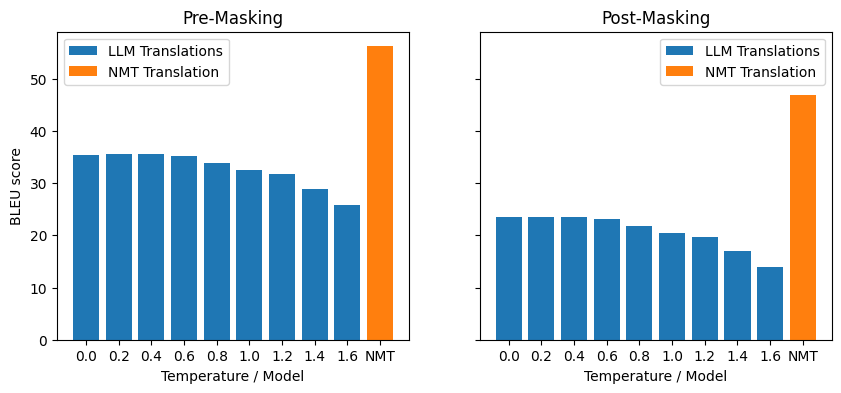

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 3.2.1: Read CSV datasets for pre- and post-masking
df_a = pd.read_csv('scores/BLEU_scores.csv')
df_b = pd.read_csv('scores/BLEU_scores-mask.csv')

# 3.2.2: Set idx to temperature and rename bleu column
df_a = df_a.set_index('temp').rename(columns={'bleu': 'LLM Translations'})
df_b = df_b.set_index('temp').rename(columns={'bleu': 'LLM Translations'})

# 3.2.3: Create subplot using two axes (share y-axis and set subplot horizontally)
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# 3.2.4: Pre-mask subplot
axes[0].bar(df_a.index.astype(str), df_a['LLM Translations'], label='LLM Translations')
axes[0].bar(['NMT'], [df_a['nmt'].iloc[0]], label='NMT Translation')
axes[0].set_title('Pre-Masking')
axes[0].set_xlabel('Temperature / Model')
axes[0].set_ylabel('BLEU score')
axes[0].legend()

# 3.2.5: Post-mask subplot
axes[1].bar(df_b.index.astype(str), df_b['LLM Translations'], label='LLM Translations')
axes[1].bar(['NMT'], [df_b['nmt'].iloc[0]], label='NMT Translation')
axes[1].set_title('Post-Masking')
axes[1].set_xlabel('Temperature / Model')
axes[1].legend()

# 3.2.6: Save plot
plt.savefig('bleu-histogram.png')

* __Part 3.3__: Load & run RM.

In [ ]:
import torch
import os
import sys
from transformers import AutoModelForSequenceClassification as amfsc, AutoTokenizer as at

# 3.3.0: Define paths
os.makedirs('reward_scores/', exist_ok=True)
inp_path = 'aligned/'
out_path = 'reward_scores/'
llm_file = f'llm_{sys.argv[1]}_Latn-aligned{sys.argv[2]}.de'
nmt_file = f'nmt_Latn-aligned{sys.argv[2]}.de'

# 3.3.1: Load Reward model and tokenizer
model_name = 'Skywork/Skywork-Reward-V2-Llama-3.1-8B'
rm = amfsc.from_pretrained(
    model_name,
    dtype=torch.bfloat16,
    device_map='auto',
    num_labels=1
)
tokenizer = at.from_pretrained(model_name)

# 3.3.3: Load preference pairs
with open(os.path.join(inp_path, llm_file), 'r') as llm, open(os.path.join(inp_path, nmt_file), 'r') as nmt:
    prefs = []
    l_lines = llm.readlines()
    n_lines = nmt.readlines()
    n = max(len(n_lines), len(l_lines))
    for i in range(n):
        nmt_sent = n_lines[i].strip()
        llm_sent = l_lines[i].strip()

        # 3.3.4: Define model inputs
        nmt_inp = tokenizer(nmt_sent, return_tensors='pt').to(device)
        llm_inp = tokenizer(llm_sent, return_tensors='pt').to(device)

        # 3.3.5: Model inference        
        with torch.no_grad():
            score_nmt = rm(**nmt_inp).logits[0][0].item()
            score_llm = rm(**llm_inp).logits[0][0].item()
        if score_llm > score_nmt:
            prefs.append('llm')
        elif score_nmt > score_llm:
            prefs.append('nmt')
        else:
            prefs.append('equal')

# 3.3.6: Save outputs
with open(os.path.join(out_path, f'{sys.argv[2]}Preference_points-{sys.argv[1]}.txt'), 'w', encoding='utf-8') as f:
    for pref in prefs:
        f.write(pref + '\n')


* __3.4__: Get the total Reward Model preferences over the total

In [ ]:
import os
import sys

path = 'reward_scores/'
out_file = f'{sys.argv[1]}Total_Reward_Score.txt'

pref_files = sorted(file for file in os.listdir(path) if file.startswith('Preference'))

with open(os.path.join(path, out_file), 'w', encoding='utf-8') as f_write:
    for idx, file in enumerate(pref_files):
        llm = 0
        nmt = 0
        equal = 0
        if file.startswith(f'{sys.argv[1]}Preference'):
            with open(os.path.join(path, file), 'r', encoding='utf-8') as f_read:
                lines = f_read.readlines()
                for line in lines:
                    if line.strip() == 'nmt':
                        nmt += 1
                    elif line.strip() == 'llm':
                        llm += 1
                    elif line.strip() == 'equal':
                        equal += 1
        f_write.write(f'''Comparing NMT translations with with LLM translations at temperature {idx*.2:.2f} yielded the following:\
                \nLLM: {llm}\nNMT: {nmt}\nEQUAL: {equal}\nHence, the model preferred the LLM {llm}/{llm+nmt} (ignoring equals) \n\n''')

#### Part 4: Mask
___
The following chunk of code is used to mask the source text before being run through the translational pipeline again.
* __4.1__: Use Named Entity Recognition (NER) to mask target text.

In [ ]:
import spacy
import os

# 4.1.0: Define paths
path = 'paraphrases/'
in_file = 'eng_Latn.txt'
out_file = 'eng_Latn-mask.txt'

# 4.1.1: Load pre-trained NER model
nlp = spacy.load('en_core_web_trf')

# 4.1.2: Mask source text and save to clean file
with open(os.path.join(path, in_file), 'r') as source, open(os.path.join(path, out_file), 'w') as target:
    lines = source.readlines()
    for line in lines:
        doc = nlp(line)
        masked_txt = line
        for ent in reversed(doc.ents):
            start, end = ent.start_char, ent.end_char
            masked_txt = masked_txt[:start] + '[MASK]' + masked_txt[end:]
        target.write(masked_txt)

/proj/uppmax2025-3-5/private/max/anaconda3/envs/nlp-gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### Part 5: Rerun pipeline with masked source data
___
This is the final step in the project pipeline and marks the end of this notebook.<br>
Run the 'execute.sh' file with all code uncommented for full notebook pipeline to be run.